# Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install pandas numpy jax sklearn selfies rdkit exmol kdeepensemble tqdm padelpy pyyaml h5py
!pip install -q tensorflowjs
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tue Feb  7 00:13:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------

In [3]:
# regular libraries
import pandas as pd
import numpy as np
import os

# ML
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
import kdens

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import MolWt

# Utils
import selfies as sf
import exmol
import urllib
from dataclasses import dataclass
import json
np.random.seed(0)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True
           })

# Getting data

In [4]:
# path = "/content/drive/MyDrive/WhiteLab/sol-nn/ml"
!unzip -o data.zip
path = "."

with open(f"{path}/voc.json", 'r') as inp:
  voc = json.load(inp)

Archive:  data.zip
  inflating: data/curated-solubility-dataset.csv  
  inflating: data/ESOL.csv           
  inflating: data/padelAqSolDB.csv   
  inflating: data/SolChal1.csv       
  inflating: data/SolChal2-1.csv     
  inflating: data/SolChal2-2.csv     


## Getting AqSolDB

In [5]:
# Is this link reliable?
# !wget -cO - https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/OVHAW8/RLVXZU > AqSolDB.tsv
# AqSolDB = pd.read_csv("AqSolDB.tsv", sep="\t")

AqSolDB = pd.read_csv(f"{path}/data/curated-solubility-dataset.csv")

descriptors = AqSolDB.iloc[:, 9:]
labels = AqSolDB["Solubility"]

print(f"The model has {len(AqSolDB)} unique entries.")

The model has 9982 unique entries.


## Getting Solubility Challenge data

In [6]:
SolChal1   = pd.read_csv(f"{path}/data/SolChal1.csv")
# sSolChal1  = pd.read_csv(f"{path}/data/SolChal1.csv") # backup df to analyze NaN entries
SolChal2_1 = pd.read_csv(f"{path}/data/SolChal2-1.csv")
SolChal2_2 = pd.read_csv(f"{path}/data/SolChal2-2.csv")

# SolChal1 = SolChal1.dropna(how="all", axis=0)

In [7]:
def calcS0(entry):
  try:
    return np.log10(1e-3*entry["expSolubility"]/MolWt(MolFromSmiles(entry["SMILES"])))
  except:
    return None

SolChal1["Solubility"] = SolChal1.apply(calcS0, axis=1)

In [8]:
#Checking for challenge molecules on training dataset
match = []
for s in pd.concat([SolChal1, SolChal2_1, SolChal2_2], axis=0)["SMILES"]:
  for a in AqSolDB["SMILES"]:
    if (a==s):
      match.append(s)

print(f"There are {'' if match else 'no'} matches between AqSolDB and the Challenges")

There are no matches between AqSolDB and the Challenges


## Getting ESOL data

In [9]:
ESOL = pd.read_csv(f"{path}/data/ESOL.csv")
ESOL = ESOL.rename({"measured log(solubility:mol/L)": "Solubility"}, axis=1)

# Analysing

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

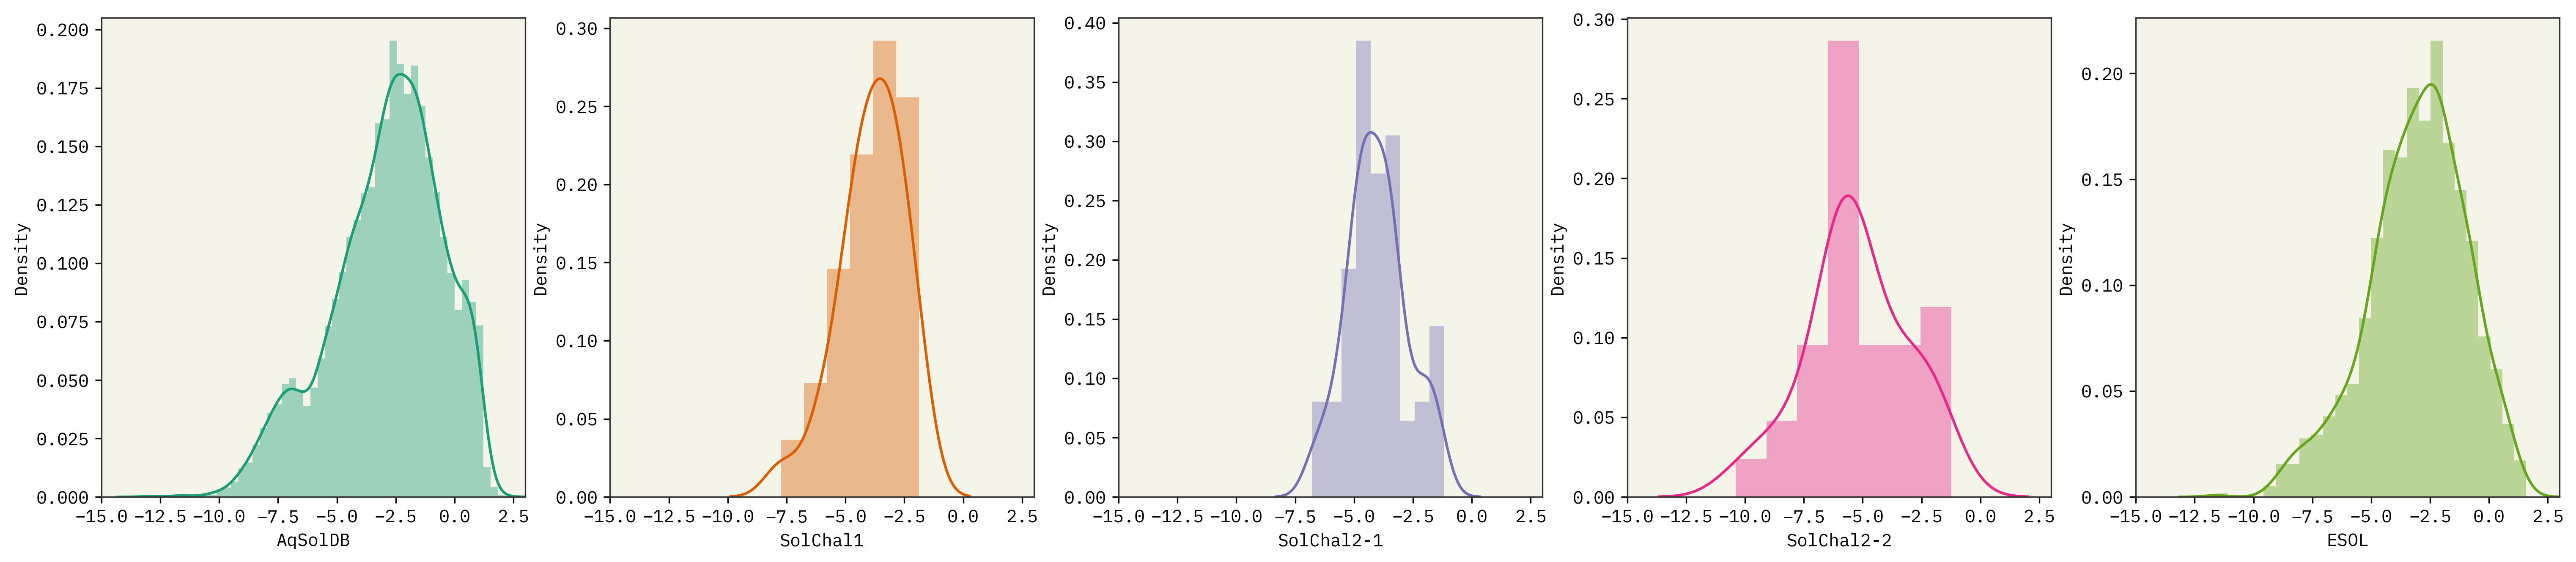

In [10]:
y = AqSolDB["Solubility"]

ys = pd.DataFrame({
    "AqSolDB": AqSolDB["Solubility"],
    "SolChal1": SolChal1["Solubility"],
    "SolChal2-1": SolChal2_1["Solubility"],
    "SolChal2-2": SolChal2_2["Solubility"],
    "ESOL" : ESOL["Solubility"]
})

fig, axs = plt.subplots(ncols=5, figsize=(25,5), dpi=300)
for i, (name, y) in enumerate(ys.items()):
  # sns.histplot(y, ax=axs[i], color=f"C{i}")
  # sns.histplot(y, ax=axs[i], color=f"black", element="poly", fill=False)
  sns.distplot(y, ax=axs[i], color=f"C{i}")
  axs[i].set_xlim(-15,3)


# Cleaning up

In [11]:
df = AqSolDB[:]

# KDENS

In [12]:
@dataclass
class Config:
    vocab_size: int = len(voc)
    example_number: int = len(df)
    batch_size: int = 16
    buffer_size: int = 10000
    rnn_units: int = 64
    hidden_dim: int = 32
    embedding_dim: int = 64
    reg_strength: float = 0.01
    lr: float = 1e-4
    drop_rate: float = 0.35
    nmodels: int = 10
    adv_epsilon: float = 1e-3
    epochs: int = 150

config = Config()
aug_data = 10
model_name = "kde10_lstm_r_f"

### Treating data

In [21]:
df_AqSolDB = AqSolDB.copy()
df_SolChal1 = SolChal1.copy()
df_SolChal2_1 = SolChal2_1.copy()
df_SolChal2_2 = SolChal2_2.copy()
df_ESOL = ESOL.copy()

In [22]:
import random
from rdkit import Chem

def randomize_smiles(mol, random_type=None, isomericSmiles=True):
    """
    From: https://github.com/rxn4chemistry/rxn_yields
    From: https://github.com/undeadpixel/reinvent-randomized and https://github.com/GLambard/SMILES-X
    Returns a random SMILES given a SMILES of a molecule.
    :param mol: A Mol object
    :param random_type: The type (unrestricted, restricted, rotated) of randomization performed.
    :return : A random SMILES string of the same molecule or None if the molecule is invalid.
    """
    if random_type is None:
      random_type = np.random.choice(['unrestricted', 'restricted', 'rotated'])

    if random_type == "unrestricted":
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=isomericSmiles)
    elif random_type == "restricted":
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=isomericSmiles)
    elif random_type == 'rotated':
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms-1)
        atoms = list(range(n_atoms))
        new_atoms_order = (atoms[rotation_index%len(atoms):]+atoms[:rotation_index%len(atoms)])
        rotated_mol = Chem.RenumberAtoms(mol,new_atoms_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=isomericSmiles)
    raise ValueError("Type '{}' is not valid".format(random_type))

smiles = list(df_AqSolDB["SMILES"])
solubilities = list(df_AqSolDB["Solubility"])

aug_smiles=[]
aug_solubilities=[]
for sml, sol in zip(smiles, solubilities):
  new_smls = []
  new_smls.append(sml)
  aug_solubilities.append(sol)
  for _ in range(aug_data):
    try:
      new_sml = randomize_smiles(Chem.MolFromSmiles(sml))
      if new_sml not in new_smls:
        new_smls.append(new_sml)
        aug_solubilities.append(sol)
    except:
      continue
  aug_smiles.extend(new_smls)

aug_df_AqSolDB = pd.DataFrame(data={
    "SMILES": aug_smiles,
    "Solubility": aug_solubilities
})

print(f"The dataset was augmented from {len(df_AqSolDB)} to {len(aug_df_AqSolDB)}.")

The dataset was augmented from 9982 to 95304.


In [23]:
def enc(smiles):
  try:
    return sf.encoder(smiles)
  except:
    # print(smiles)
    return None

sf.set_semantic_constraints("default")
aug_df_AqSolDB["SELFIES"] = aug_df_AqSolDB["SMILES"].map(enc)
aug_df_AqSolDB = aug_df_AqSolDB.dropna()

df_SolChal1["SELFIES"] = df_SolChal1["SMILES"].map(enc)
df_SolChal2_1["SELFIES"] = df_SolChal2_1["SMILES"].map(enc)
df_SolChal2_2["SELFIES"] = df_SolChal2_2["SMILES"].map(enc)
df_ESOL["SELFIES"] = df_ESOL["SMILES"].map(enc)

In [24]:
# alphabet = ["[nop]", "."]
# alphabet.extend(voc.keys())
# sfs_alphabet = sf.get_alphabet_from_selfies(aug_df_AqSolDB["SELFIES"])
# alphabet.extend(sfs_alphabet)
# alphabet.extend([k for k in voc.keys() if k not in alphabet])

alphabet = voc.keys()
pad_to_len = max(sf.len_selfies(s) for s in aug_df_AqSolDB["SELFIES"])
voc = {s: i for i, s in enumerate(alphabet)}

# Saving the voc
# with open(f"{path}/voc.json", 'w') as out:
  # out.write(json.dumps(voc, indent = 4))

In [25]:
def stoi(selfies):
  try:
    label, one_hot = sf.selfies_to_encoding(
      selfies=selfies,
      vocab_stoi=voc,
      pad_to_len=pad_to_len,
      enc_type="both"
    )
  except:
    # print(selfies)
    return None
  return label

aug_df_AqSolDB["SELFIES_TOKENS"] = aug_df_AqSolDB["SELFIES"].map(stoi)
# aug_df_AqSolDB = aug_df_AqSolDB.dropna()
# aug_df_AqSolDB = aug_df_AqSolDB.sample(frac=1, replace=True).reset_index(drop=True)
aug_df_AqSolDB = aug_df_AqSolDB[aug_df_AqSolDB["SELFIES_TOKENS"].str.len() <= 512]

df_SolChal1["SELFIES_TOKENS"]   = df_SolChal1["SELFIES"].map(stoi)
df_SolChal2_1["SELFIES_TOKENS"] = df_SolChal2_1["SELFIES"].map(stoi)
df_SolChal2_2["SELFIES_TOKENS"] = df_SolChal2_2["SELFIES"].map(stoi)
df_ESOL["SELFIES_TOKENS"] = df_ESOL["SELFIES"].map(stoi)

In [26]:
# Preparing data for training
# soldata = pd.read_csv('data/curated-solubility-dataset.csv')
soldata = df_AqSolDB
soldata.head()

aug_smiles = []
aug_labels = []

for s,l in zip(soldata.SMILES, soldata.Solubility):
  m, s, r = exmol.sanitize_smiles(s)
  if not r:
    continue
  aug_smiles.append(s)
  aug_labels.append(l)
  for _ in range(aug_data):
    try:
      si = randomize_smiles(m)
    except RuntimeError:
      break
    if si is not None and si != s:
      aug_smiles.append(si)
      aug_labels.append(l)
print('Before Augmentation', len(soldata.SMILES), 'After augmentation', len(aug_smiles))

selfies_list = []
for s in aug_smiles:
  try:
    se = sf.encoder(s)
    selfies_list.append(se) if len(se)<512 else selfies_list.append(None)
  except:
    # print(s)
    selfies_list.append(None)

# basic = set(exmol.get_basic_alphabet())
# data_vocab = set(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
# vocab = ['[Nop]', '.']
# vocab.extend(list(data_vocab.union(basic)))
vocab = voc.keys()
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token in vocab_stoi:
          result.append(vocab_stoi[token])
        else:
          # print(token)
          result.append(0) #[nop]  #np.nan)
          #print('Warning')
    return result

def ints2selfies(v):
    return ''.join([vocab[i] for i in v])


Before Augmentation 9982 After augmentation 105347


In [27]:
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")
aug_labels = np.array(aug_labels)
sol_values = aug_labels[[bool(s) for s in selfies_list]].astype(np.float32)

# there may be some contaimation from augmentation in one record, but is negligible
# shuffle before split
N = len(sol_values)
i = np.arange(N)
np.random.shuffle(i)
padded_seqs = padded_seqs[i]
sol_values = sol_values[i]
print(N, 'Total examples')

split = int(0.2 * N)
test_data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs[:split], sol_values[:split]))
val_data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs[split:2*split], sol_values[split:2*split]))

sol_values = sol_values[2*split:]
padded_seqs = padded_seqs[2*split:]

idx = kdens.resample(sol_values, (sol_values.shape[0], config.nmodels))
train_data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs[idx], sol_values[idx].astype(np.float32))
    )

test_data = test_data.batch(config.batch_size)
val_data = val_data.batch(config.batch_size).cache().prefetch(
        tf.data.AUTOTUNE
    )
train_data = train_data.shuffle(config.buffer_size).batch(config.batch_size).prefetch(
        tf.data.AUTOTUNE
    )

103703 Total examples


### Creating the model

In [28]:
def build_model():
    inputs = tf.keras.Input(shape=(None,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size,
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)
    e = tf.keras.layers.Dropout(config.drop_rate)(e)
    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True,  kernel_regularizer='l2'))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, kernel_regularizer='l2'))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(config.hidden_dim, activation="swish",  kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(config.hidden_dim // 2, activation="swish",  kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    muhat = tf.keras.layers.Dense(1)(x)
    stdhat = tf.keras.layers.Dense(1,
                                   activation='softplus',
                                   bias_constraint=tf.keras.constraints.MinMaxNorm(
                                       min_value=1e-6, max_value=1000.0, rate=1.0, axis=0))(x)
    out = tf.squeeze(tf.stack([muhat, stdhat], axis=-1))
    model = tf.keras.Model(inputs=inputs, outputs=out, name='sol-rnn')
    partial_in = tf.keras.Model(inputs=inputs, outputs=e)
    partial_out = tf.keras.Model(inputs=e, outputs=out)
    return model, partial_in, partial_out

def build_inf_model():
    inputs = tf.keras.Input(shape=(None,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size,
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(config.hidden_dim, activation="swish")(x)
    x = tf.keras.layers.Dense(config.hidden_dim // 2, activation="swish")(x)
    # predicting prob, so no activation
    muhat = tf.keras.layers.Dense(1)(x)
    stdhat = tf.keras.layers.Dense(1, activation='softplus')(x)
    out = tf.squeeze(tf.stack([muhat, stdhat], axis=-1))
    model = tf.keras.Model(inputs=inputs, outputs=out, name='sol-rnn-infer')
    # model = tf.keras.Model(inputs=inputs, outputs=(muhat, stdhat), name='sol-rnn-infer')
    return model

### Training

In [32]:
model = kdens.DeepEnsemble(build_model, config.nmodels, config.adv_epsilon, partial=True)
model.compile(tf.optimizers.Adam(1e-4),
              loss=kdens.neg_ll,
              metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()],
              run_eagerly=False)

In [33]:
result = model.fit(train_data,
                   validation_data=val_data,
                   epochs=config.epochs,
                  callbacks=[
                    # tf.keras.callbacks.ModelCheckpoint(filepath=f"{path}/{model_name}/checkpoint",
                    #                                   verbose=0,
                    #                                   save_best_only=True,
                    #                                   save_weights_only=True,
                    #                                   mode='max'),
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     mode='min',
                                                     restore_best_weights=True,
                                                     patience=65)
                    ])

Epoch 1/3
370/370 [==============================] - 442s 762ms/step - loss: 41.7344 - adv_loss: 41.7666 - mean_squared_error: 28.1201 - mean_absolute_error: 4.3230 - val_loss: 21.4881 - val_mean_squared_error: 4.4424 - val_mean_absolute_error: 1.7310 - val_adv_loss: 0.0000e+00
Epoch 2/3
370/370 [==============================] - 209s 564ms/step - loss: 16.3237 - adv_loss: 16.3697 - mean_squared_error: 20.5992 - mean_absolute_error: 3.6280 - val_loss: 10.2336 - val_mean_squared_error: 5.4344 - val_mean_absolute_error: 1.9562 - val_adv_loss: 0.0000e+00
Epoch 3/3
370/370 [==============================] - 214s 578ms/step - loss: 9.1869 - adv_loss: 9.2741 - mean_squared_error: 17.2768 - mean_absolute_error: 3.3020 - val_loss: 6.4364 - val_mean_squared_error: 5.1503 - val_mean_absolute_error: 1.8724 - val_adv_loss: 0.0000e+00


In [38]:
inference_model = kdens.DeepEnsemble(build_inf_model, config.nmodels, config.adv_epsilon)
inference_model.set_weights(model.get_weights())
inference_model.compile(tf.optimizers.Adam(1e-4), loss=kdens.neg_ll, metrics=['mae'])

In [43]:
# Save model for netron
# inference_model.save(f"{model_name}_model.h5")

model_path = f"{path}/{model_name}"
if not os.path.exists(model_path):
  os.makedirs(f"{model_path}")

# Save training history
with open(f"{model_path}/history.json", 'w') as out:
  out.write(json.dumps(result.history, indent = 4))

# Save training history
for i, m in enumerate(inference_model.models):
  # serialize model to JSON
  inference_model_json = m.to_json()
  with open(f"{model_path}/m{i}.json", "w") as json_file:
      json_file.write(inference_model_json)
  # serialize weights to HDF5
  m.save_weights(f"{model_path}/m{i}.h5")
  # tfjs.converters.save_keras_model(inference_model, "../models/sol-rnn/")

In [41]:
from google.colab import files
!zip {model_name}.zip {model_name}

files.download(f"{model_name}.zip")

updating: kde10_lstm_r_f/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluating

In [29]:
# !tar -xvf {model_name}.tar
! unzip -o {model_name}.zip
model_path = f"{path}/{model_name}"

# loading training history
with open(f"{model_path}/history.json", 'r') as inp:
  result = json.load(inp)

models = []
for i in range(config.nmodels):
  with open(f"{model_path}/m{i}.json", "r") as json_file:
    json_model = json_file.read()
    m = tf.keras.models.model_from_json(json_model)
    m.load_weights(f"{model_path}/m{i}.h5")

    models.append(m)
    # models[i].load_weights(f"{model_path}/m{i}.h5")

m = kdens.DeepEnsemble(build_inf_model, config.nmodels, config.adv_epsilon)
m.models = models

m.compile(
    tf.optimizers.Adam(),
    loss=kdens.neg_ll,
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

Archive:  kde10_lstm_r_f.zip
  inflating: kde10_lstm_r_f/m3.json  
  inflating: kde10_lstm_r_f/history.json  
  inflating: kde10_lstm_r_f/m1.json  
  inflating: kde10_lstm_r_f/m7.json  
  inflating: kde10_lstm_r_f/m5.json  
  inflating: kde10_lstm_r_f/m4.json  
  inflating: kde10_lstm_r_f/kde10_lstm_r_f_varDist.png  
  inflating: kde10_lstm_r_f/kde10_lstm_r_f_sdDist.png  
  inflating: kde10_lstm_r_f/m0.json  
  inflating: kde10_lstm_r_f/m8.json  
  inflating: kde10_lstm_r_f/checkpoint  
  inflating: kde10_lstm_r_f/kde10_lstm_r_f_solChalDB.png  
  inflating: kde10_lstm_r_f/m9.json  
  inflating: kde10_lstm_r_f/checkpoint.index  
  inflating: kde10_lstm_r_f/m6.json  
  inflating: kde10_lstm_r_f/m5.h5    
  inflating: kde10_lstm_r_f/m2.json  
  inflating: kde10_lstm_r_f/m6.h5    
  inflating: kde10_lstm_r_f/m2.h5    
  inflating: kde10_lstm_r_f/m9.h5    
  inflating: kde10_lstm_r_f/m8.h5    
  inflating: kde10_lstm_r_f/m1.h5    
  inflating: kde10_lstm_r_f/m0.h5    
  inflating: kde10_lst

In [30]:
# train_data is a shuffled tf object
# it'd be randomly sampled and it'd unsynchronize x and y in mse computing
X_train, y_train = [], []
for x, y in train_data.unbatch():
  X_train.append(x)
  y_train.append(y)

train = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
    ).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

X_train, y_train = (np.concatenate([x[0].numpy() for x in train.unbatch()]),
                    np.concatenate([y for x, y in train]))
X_test, y_test = (np.concatenate([x[0].numpy()[np.newaxis,...] for x in test_data.unbatch()]),
                  np.concatenate([y for x, y in test_data]))
X_val, y_val = (np.concatenate([x[0].numpy()[np.newaxis,...] for x in val_data.unbatch()]),
                np.concatenate([y for x, y in val_data]))


In [31]:
from matplotlib.pyplot import figure

def mse(y, pred):
  # return np.mean((y-pred)**2)
  return mean_squared_error(y, pred)

def mae(y, pred):
  return mean_absolute_error(y, pred)

def r2(y, pred):
  return r2_score(y, pred)

def corr(y, pred):
  return np.corrcoef(y, pred)[0,1]

def acc(y, pred, threshold):
  acc = sum((abs(pred - y)<threshold))/len(pred)
  return acc


def eval(model, y, X):
  th = 0.5
  figure(figsize=(4, 4), dpi=300)
  pred = model.predict(X)[:,0]
  yvar = model.predict(X)[:,1]

  lim = (-13.0,3.0)
  upper = (lim[0]+th, lim[1]+th)
  lower = (lim[0]-th, lim[1]-th)

  plt.plot(lim,lim, color='gray')
  plt.plot(y, y, color='gray')
  # plt.scatter(y, pred, marker="o", s=6, alpha=0.5)
  plt.plot(y, pred, marker="o", linestyle="", alpha=0.5)
  plt.errorbar(y, pred, yerr=np.sqrt(yvar), fmt='.', color='gray', alpha=0.05)
  plt.plot(lim, upper, color='red', alpha=0.3, ls='--')
  plt.plot(lim, lower, color='red', alpha=0.3, ls='--')
  plt.xlim(lim)
  plt.ylim(lim)
  plt.xlabel("label LogS")
  plt.ylabel("predicted LogS")
  # plt.text(min(y) + 1, max(y) - 2, f"r-sq = {r2(y, pred):.3f}")
  plt.text(lim[0] + 1, lim[1] - 2, f"corr = {corr(y, pred):.3f}")
  plt.text(lim[0] + 1, lim[1] - 3, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  plt.text(lim[0] + 1, lim[1] - 4, f"MAE = {mae(y, pred):.3f}")
  plt.text(lim[0] + 1, lim[1] - 5, f"acc-{th} = {acc(y, pred, th):.3f}")
  plt.tight_layout()
  plt.savefig(f"{model_path}/{model_name}_eval.png", dpi=300)

def eval_SD(model, y, X):
  pred = model.predict(X)[:,0]
  yvar = model.predict(X)[:,1]

  plt.plot(y, np.sqrt(yvar), color="orange", marker="o", linestyle="", alpha=0.4)
  plt.plot(y, y, color='gray')
  plt.xlim(min(y), max(y))
  plt.ylim(min(y), max(y))
  plt.xlabel("label SD")
  plt.ylabel("predicted sqrt(var)")
  # plt.text(min(y) + 1, max(y) - 2, f"r-sq = {r2(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 2, f"corr = {corr(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 3, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  plt.text(min(y) + 1, max(y) - 4, f"MAE = {mae(y, pred):.3f}")
  plt.tight_layout()
  plt.savefig(f"{model_path}/{model_name}_eval_SD.png", dpi=500)

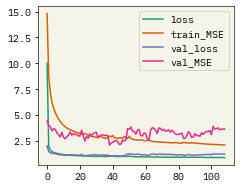

In [32]:
with open(f"{model_path}/history.json", 'r') as json_h:
  history = json.load(json_h)

plt.plot(history['loss'], label="loss")
plt.plot(history['mean_squared_error'], label="train_MSE")
plt.plot(history['val_loss'], label="val_loss")
plt.plot(history['val_mean_squared_error'], label="val_MSE")
plt.legend()
plt.show()

649/649 [==============================] - 10s 15ms/step


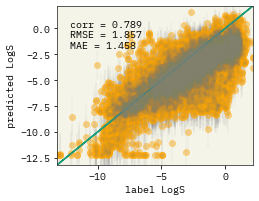

649/649 [==============================] - 8s 12ms/step


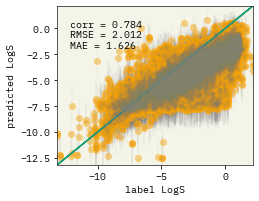

649/649 [==============================] - 9s 13ms/step


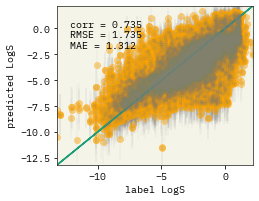

649/649 [==============================] - 10s 15ms/step


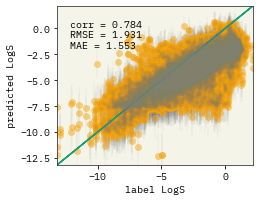

649/649 [==============================] - 9s 14ms/step


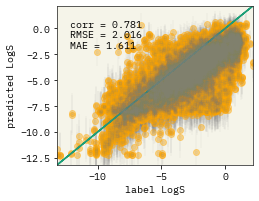

649/649 [==============================] - 10s 16ms/step


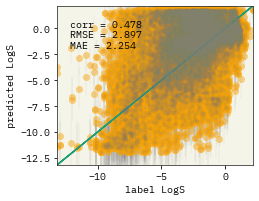

649/649 [==============================] - 8s 13ms/step


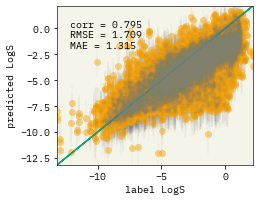

649/649 [==============================] - 9s 14ms/step


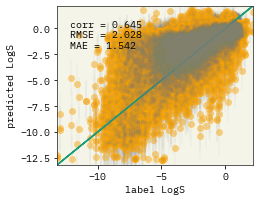

649/649 [==============================] - 9s 13ms/step


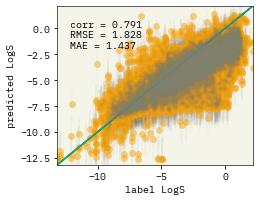

649/649 [==============================] - 9s 14ms/step


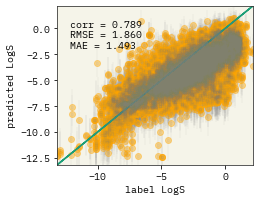

In [33]:
for mi in m.models:
  # Assert that each model is working
  pred = mi.predict(X_val)[:,0]
  yvar = mi.predict(X_val)[:,1]
  y=y_val

  plt.plot(y, pred, color="orange", marker="o", linestyle="", alpha=0.4)
  plt.errorbar(y, pred, yerr=np.sqrt(yvar), fmt='.', color='gray', alpha=0.05)
  plt.plot(y, y)
  plt.xlim(min(y), max(y))
  plt.ylim(min(y), max(y))
  plt.xlabel("label LogS")
  plt.ylabel("predicted LogS")
  plt.text(min(y) + 1, max(y) - 2, f"corr = {corr(y, pred):.3f}")
  plt.text(min(y) + 1, max(y) - 3, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  plt.text(min(y) + 1, max(y) - 4, f"MAE = {mae(y, pred):.3f}")
  plt.show()


649/649 [==============================] - 83s 128ms/step
Acc[0.5] = 26.63%
Acc[1.0] = 49.37%
Acc[1.5] = 68.39%
Acc[2.0] = 81.56%
Acc[2.5] = 89.37%


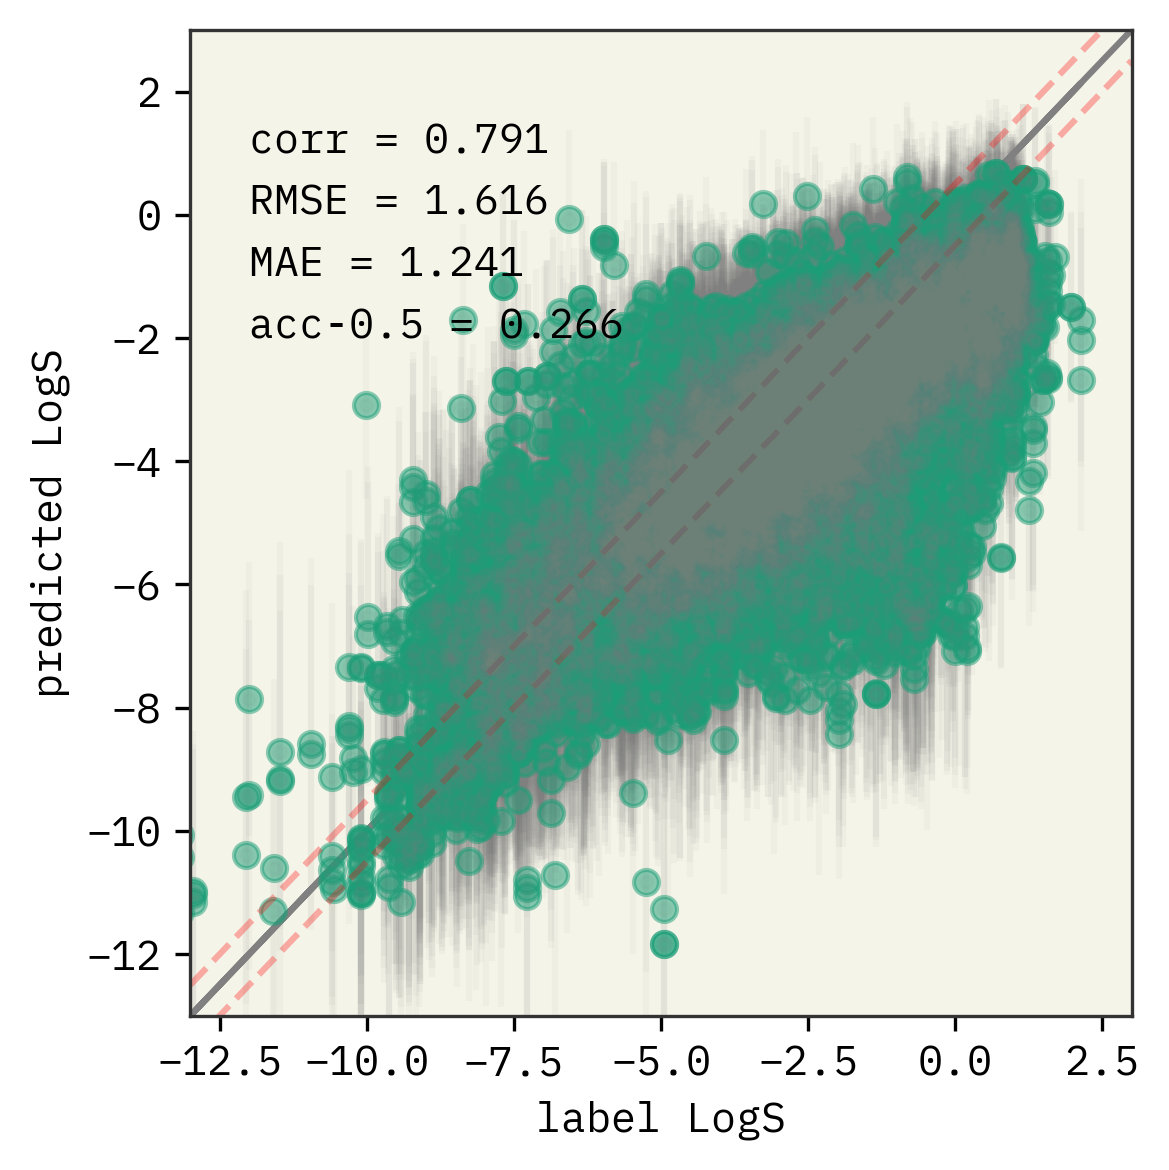

In [34]:
# print(f"Train => MSE: {mse(y_train, m(X_train)[:,0]): 3.4f}")
# print(f"Test  => MSE: {mse(y_test, m.predict(X_test)[:,0]): 3.4f}")
# print(f"Valid => MSE: {mse(y_val, m.predict(X_val)[:,0]): 3.4f}\n")

eval(m, y_val, X_val)

pred = m.predict(X_val)[:,0]
for th in np.arange(0.5, 3.0, 0.5):
  print(f"Acc[{th}] = {acc(y_val, pred, th)*100:.2f}%")

In [35]:
df_SolChal1_data = df_SolChal1.dropna(axis=0)
df_SolChal1_data = tf.data.Dataset.from_tensor_slices(
    (df_SolChal1_data["SELFIES_TOKENS"].to_list(), df_SolChal1_data["Solubility"].to_list())
    )

df_SolChal2_1_data = df_SolChal2_1.dropna(axis=0)
df_SolChal2_1_data = tf.data.Dataset.from_tensor_slices(
    (df_SolChal2_1_data["SELFIES_TOKENS"].to_list(), df_SolChal2_1_data["Solubility"].to_list())
    )

df_SolChal2_2_data = df_SolChal2_2.dropna(axis=0)
df_SolChal2_2_data = tf.data.Dataset.from_tensor_slices(
    (df_SolChal2_2_data["SELFIES_TOKENS"].to_list(), df_SolChal2_2_data["Solubility"].to_list())
    )

df_ESOL_data = df_ESOL.dropna(axis=0)
df_ESOL_data = tf.data.Dataset.from_tensor_slices(
    (df_ESOL_data["SELFIES_TOKENS"].to_list(), df_ESOL_data["Solubility"].to_list())
    )


1/1 [==============================] - 0s 165ms/step


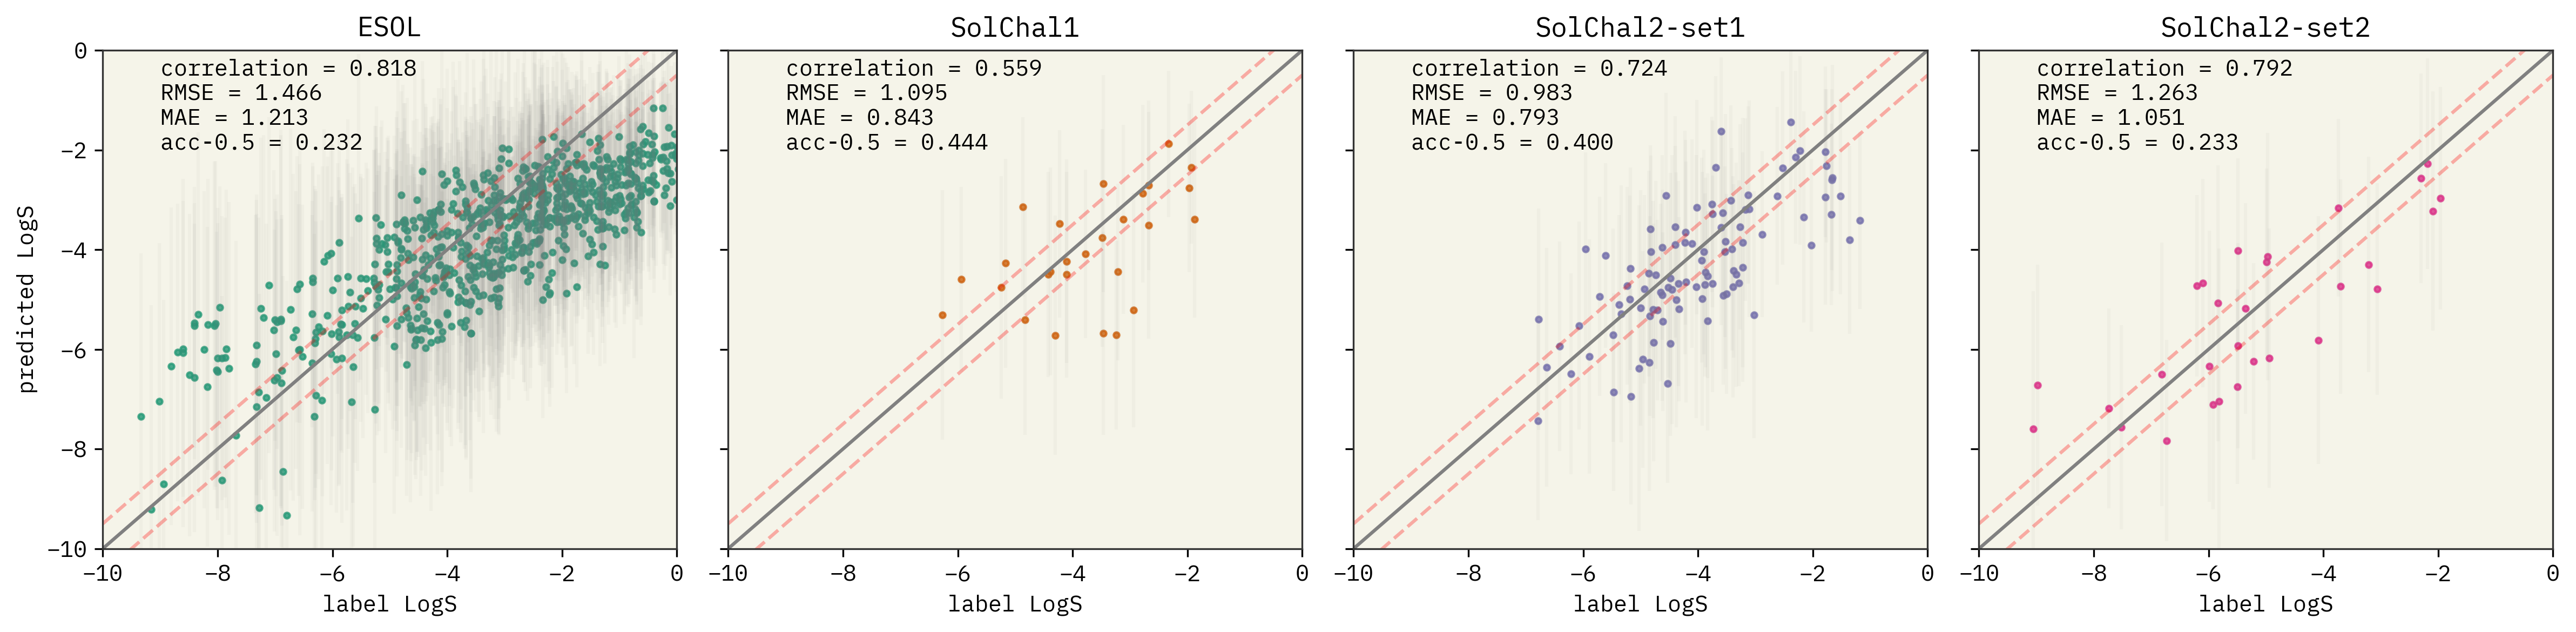

In [36]:
dbs = {"ESOL": df_ESOL_data,
       "SolChal1":df_SolChal1_data,
       "SolChal2-set1":df_SolChal2_1_data,
       "SolChal2-set2":df_SolChal2_2_data,
       }

th=0.5

fig, axs = plt.subplots(nrows=1, ncols=len(dbs), sharey=True, figsize=(16, 4), dpi=300)
for i, (name, db) in enumerate(dbs.items()):
  ax = axs[i]
  y = [y.numpy() for x, y in db]
  X = db.batch(888) #huge batch to take all data
  pred = m.predict(X)[:,0]
  yvar = m.predict(X)[:,1]

  ax.scatter(
      y, pred, s=6, alpha=0.8, color=f"C{i}"
  )
  ax.errorbar(y, pred, yerr=np.sqrt(yvar), fmt='.', color='gray', alpha=0.05)

  lim = (-10.0,0.0)
  upper = (lim[0]+th, lim[1]+th)
  lower = (lim[0]-th, lim[1]-th)
  ax.plot(lim,lim, color='gray')
  ax.plot(lim, upper, color='red', alpha=0.3, ls='--')
  ax.plot(lim, lower, color='red', alpha=0.3, ls='--')
  ax.set_title(name)
  # ax.set_xlim([min(y), max(y)])
  # ax.set_ylim([min(y), max(y)])
  ax.set_xlim(lim)
  ax.set_ylim(lim)
  ax.set_xlabel("label LogS")
  if (i==0):
    ax.set_ylabel("predicted LogS")

  # plt.text(min(y) + 1, max(y) - 1, f"correlation = {np.corrcoef(y, pred)[0,1]:.3f}")
  # ax.text(lim[0] + 1, lim[1] - 0.5, f"r-sq = {r2(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 0.5, f"correlation = {corr(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 1.0, f"RMSE = {np.sqrt(mse(y, pred)):.3f}")
  ax.text(lim[0] + 1, lim[1] - 1.5, f"MAE = {mae(y, pred):.3f}")
  ax.text(lim[0] + 1, lim[1] - 2.0, f"acc-{th} = {acc(y, pred, th):.3f}")
plt.tight_layout()
plt.savefig(f"{model_path}/{model_name}_solChalDB.png")
plt.show()


1/1 [==============================] - 1s 520ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1/1 [==============================] - 0s 152ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1/1 [==============================] - 0s 377ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1/1 [==============================] - 0s 158ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


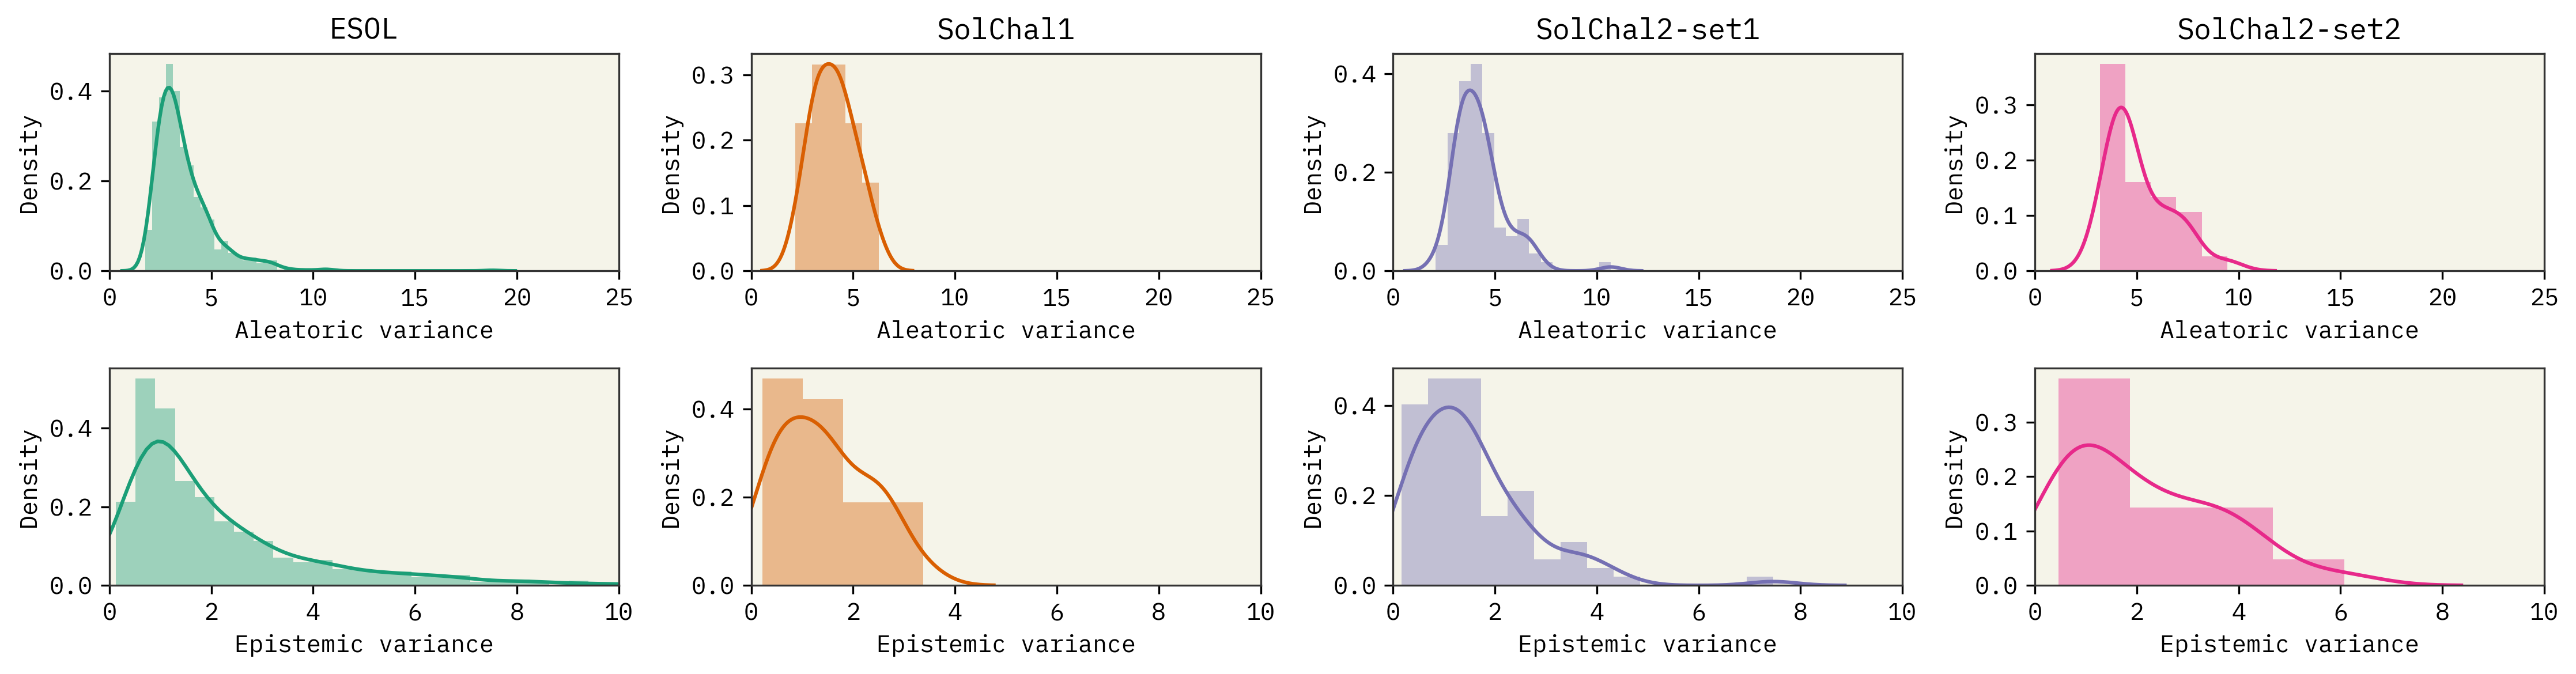

In [37]:
dbs = {"ESOL": df_ESOL_data,
       "SolChal1":df_SolChal1_data,
       "SolChal2-set1":df_SolChal2_1_data,
       "SolChal2-set2":df_SolChal2_2_data,
       }

fig, axs = plt.subplots(nrows=2, ncols=4, sharey=False, figsize=(15, 4), dpi=300)
for i, (name, db) in enumerate(dbs.items()):
  axl = axs.flatten()
  axvar = axl[i]
  axepi = axl[i+4]

  y = [y.numpy() for x, y in db]
  X = db.batch(888) #huge batch to take all data
  pred = m.predict(X)[:,0]
  yvar = m.predict(X)[:,1]
  epi_var  = m.predict(X)[:,2]


  sns.distplot(yvar, ax = axvar, color=f"C{i}")
  axvar.set_xlim((0,25))
  axvar.set_title(name)
  axvar.set_xlabel("Aleatoric variance")

  sns.distplot(epi_var, ax = axepi, color=f"C{i}")
  axepi.set_xlim((0,10))
  axepi.set_xlabel("Epistemic variance")

plt.tight_layout()
plt.savefig(f"{model_path}/{model_name}_varDist.png")
plt.show()

In [38]:
import tensorflowjs as tfjs
import json

pred = m.predict(X_val)[:,0]
y = y_val

metric_r = corr(y, pred)
metric_rscore = r2(y, pred)
metric_mae = mae(y, pred)

print(metric_r)
print(metric_rscore)
print(metric_mae)
for i,mi in enumerate(m.models):
  nm = build_inf_model()
  nm.set_weights(mi.get_weights())
  # call to make sure it's built
  nm(x)
  tfjs.converters.save_keras_model(nm, f"{model_path}/models/{i}")

with open(f'{model_path}/models/vocab.json', 'w') as f:
  json.dump(dict(vocab=list(vocab), vocab_stoi=vocab_stoi), f)

model_card = {
    'title': 'Solubility Prediction',
    'details': 'Solubility predictor with uncertainty. Model is a bidirectional LSTM that predict standard deviation and mean. An ensemble of 10 is combined for predictions. Epistemic uncertainty comes from model disagreement.',
    'use': 'Organic molecules',
    'factors': 'Model may not generalize to large molecules, very insoluble (< -12.5 logS), and highly soluble (> 1 logS), ions, or metals.',
    'metrics': f'Test correlation {metric_r:.2f}. Test MAE {metric_mae:.2f}',
    'evaluation': 'Withheld examples (test data)',
    # 'training': f'{len(soldata.SMILES)} molecules, which was augmented to {len(aug_smiles)} molecules.',
    'training': f'{len(soldata.SMILES)} molecules, which was augmented to 96625 molecules.',
    'caveats': 'Check the parity plot to see where your molecule falls relative to the training curve.',
    'ethics': 'None noted',
    'image': 'https://raw.githubusercontent.com/ur-whitelab/exmol.io/main/models/rnn-fit.png'
  }
with open(f'{model_path}/models/card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

649/649 [==============================] - 81s 124ms/step
0.7911968085098262
0.520982926573742
1.2414935


{
 "title": "Solubility Prediction",
 "details": "Solubility predictor with uncertainty. Model is a bidirectional LSTM that predict standard deviation and mean. An ensemble of 10 is combined for predictions. Epistemic uncertainty comes from model disagreement.",
 "use": "Organic molecules",
 "factors": "Model may not generalize to large molecules, very insoluble (< -12.5 logS), and highly soluble (> 1 logS), ions, or metals.",
 "metrics": "Test correlation 0.79. Test MAE 1.24",
 "evaluation": "Withheld examples (test data)",
 "training": "9982 molecules, which was augmented to 96625 molecules.",
 "caveats": "Check the parity plot to see where your molecule falls relative to the training curve.",
 "ethics": "None noted",
 "image": "https://raw.githubusercontent.com/ur-whitelab/exmol.io/main/models/rnn-fit.png"
}
